In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
import mlflow
import mlflow.sklearn
import joblib
import sqlite3
from sqlalchemy import create_engine

In [2]:
import pandas as pd
import sqlite3

# Step 1: Create a SQLite Database
db_path = '/Users/kaushalshivaprakash/Desktop/ML project1/gpu_data.db'
conn = sqlite3.connect(db_path)

# Step 2: Load Raw Data
raw_data_path = '/Users/kaushalshivaprakash/Desktop/ML project1/GPU_benchmarks1.csv'
gpu_data = pd.read_csv(raw_data_path)

# Step 3: Create and Populate the Categories Table
categories = pd.DataFrame({
    'category_name': ['Unknown', 'Desktop', 'Workstation', 'Mobile', 'Mobile, Workstation', 'Desktop, Mobile']
})
categories['category_id'] = range(1, len(categories) + 1)
categories.to_sql('Categories', conn, if_exists='replace', index=False)

# Step 4: Retrieve category IDs for foreign key reference
categories_lookup = pd.read_sql("SELECT * FROM Categories", conn)

# Step 5: Merge category IDs into the GPU data
gpu_data = gpu_data.merge(categories_lookup, left_on='category', right_on='category_name')

# Step 6: Rename 'gpuName' to 'GPU_Name' for consistency
gpu_data.rename(columns={'gpuName': 'GPU_Name'}, inplace=True)

# Step 7: Insert data into GPUs table
gpus = gpu_data[['GPU_Name', 'TDP', 'category_id']]
gpus.to_sql('GPUs', conn, if_exists='replace', index=False)

# Step 8: Retrieve GPUs table to verify insertion
gpus_lookup = pd.read_sql("SELECT rowid AS GPU_ID, GPU_Name, TDP, category_id FROM GPUs", conn)

# Debugging: Check the GPUs Lookup Table
print("\nGPUs Lookup Table:")
print(gpus_lookup)

# Step 9: Merge GPU IDs into the performance data
gpu_data = gpu_data.merge(gpus_lookup[['GPU_ID', 'GPU_Name']], on='GPU_Name', how='left')

# Debugging: Check gpu_data after merging GPU_ID
print("\nGPU Data After Merging GPU IDs:")
print(gpu_data.head())

# Step 10: Insert data into Performance table
performance = gpu_data[['GPU_ID', 'G3Dmark', 'G2Dmark', 'gpuValue', 'powerPerformance', 'price']]
performance.to_sql('Performance', conn, if_exists='replace', index=False)

print("\nPerformance Table Inserted Successfully")

# Close the connection
conn.close()



GPUs Lookup Table:
      GPU_ID                             GPU_Name    TDP  category_id
0          1                  GeForce RTX 3090 Ti  450.0            1
1          2                  GeForce RTX 3080 Ti  350.0            2
2          3                     GeForce RTX 3090  350.0            2
3          4                    Radeon RX 6900 XT  300.0            2
4          5                     GeForce RTX 3080  320.0            2
...      ...                                  ...    ...          ...
2312    2313  Intel 82852/82855 GM/GME Controller  200.0            1
2313    2314                          Quadro2 Pro   68.0            3
2314    2315                         Rage 128 Pro  200.0            1
2315    2316             RAGE 128 PRO AGP 4X TMDS  200.0            1
2316    2317                      S3 ProSavageDDR  200.0            1

[2317 rows x 4 columns]

GPU Data After Merging GPU IDs:
              GPU_Name  G3Dmark  G2Dmark    price   gpuValue    TDP  \
0  GeForce 

In [3]:
import pandas as pd
import sqlite3

# Step 1: Connect to the SQLite Database
db_path = '/Users/kaushalshivaprakash/Desktop/ML project1/gpu_data.db'
conn = sqlite3.connect(db_path)

# Step 2: SQL Join Statement to Fetch Data (updated to use rowid)
query = """
SELECT 
    g.rowid AS GPU_ID,
    g.GPU_Name,
    g.TDP,
    c.category_name,
    p.G3Dmark,
    p.G2Dmark,
    p.gpuValue,
    p.powerPerformance,
    p.price
FROM 
    GPUs g
JOIN 
    Categories c ON g.category_id = c.category_id
JOIN 
    Performance p ON g.rowid = p.GPU_ID
"""

# Step 3: Execute the query and load into a DataFrame
gpu_performance_data = pd.read_sql(query, conn)

# Step 4: Display the DataFrame
print(gpu_performance_data.head())

print(gpu_performance_data.info())

# Step 5: Close the connection
conn.close()


   GPU_ID             GPU_Name    TDP category_name  G3Dmark  G2Dmark  \
0       1  GeForce RTX 3090 Ti  450.0       Unknown    29094     1117   
1       2  GeForce RTX 3080 Ti  350.0       Desktop    26887     1031   
2       3     GeForce RTX 3090  350.0       Desktop    26395      999   
3       4    Radeon RX 6900 XT  300.0       Desktop    25458     1102   
4       5     GeForce RTX 3080  320.0       Desktop    24853     1003   

    gpuValue  powerPerformance    price  
0  13.854352         64.653333  2099.99  
1  22.406020         76.820000  1199.99  
2  15.082943         75.414286  1749.99  
3  22.724067         84.860000  1120.31  
4  24.877878         77.665625   999.00  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2317 entries, 0 to 2316
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   GPU_ID            2317 non-null   int64  
 1   GPU_Name          2317 non-null   object 
 2   TDP       

In [4]:
import pandas as pd
import sqlite3

# Step 1: Connect to the SQLite Database
db_path = '/Users/kaushalshivaprakash/Desktop/ML project1/gpu_data.db'
conn = sqlite3.connect(db_path)

# Step 2: Load Raw GPU Data
raw_data_path = '/Users/kaushalshivaprakash/Desktop/ML project1/GPU_benchmarks1.csv'
gpu_data = pd.read_csv(raw_data_path)

# Step 3: Define classification logic based on TDP and price
def classify_gpu(row):
    if pd.isna(row['TDP']) and pd.isna(row['price']):
        return 'Unknown'
    
    if not pd.isna(row['TDP']):
        if row['TDP'] <= 75:
            if 'Mobile' in row['gpuName'] or 'M' in row['gpuName'].split()[-1]:
                return 'Mobile'
            else:
                return 'Desktop'
        elif 75 < row['TDP'] <= 200:
            return 'Desktop'
        else:
            return 'Workstation'
    
    # If TDP is missing, use price and other indicators
    if not pd.isna(row['price']):
        if row['price'] < 300 or 'Mobile' in row['gpuName'] or 'M' in row['gpuName'].split()[-1]:
            return 'Mobile'
        elif 300 <= row['price'] <= 1000:
            return 'Desktop'
        else:
            return 'Workstation'
    
    # If both TDP and price are missing, use name-based heuristics
    if 'Mobile' in row['gpuName'] or 'M' in row['gpuName'].split()[-1]:
        return 'Mobile'
    elif 'Quadro' in row['gpuName'] or 'Workstation' in row['gpuName'] or 'Pro' in row['gpuName']:
        return 'Workstation'
    else:
        return 'Desktop'

# Step 4: Apply classification to the dataset
gpu_data['category'] = gpu_data.apply(classify_gpu, axis=1)

# Step 5: Update the Categories table in SQLite
categories_updated = pd.DataFrame({
    'category_name': ['Mobile', 'Desktop', 'Workstation']
})
categories_updated['category_id'] = range(1, len(categories_updated) + 1)

# Overwrite the existing Categories table
categories_updated.to_sql('Categories', conn, if_exists='replace', index=False)

# Step 6: Map updated category IDs back to the GPU data
categories_lookup_updated = pd.read_sql("SELECT * FROM Categories", conn)

# Debugging: Check column names before merge
print("\nColumns in categories_lookup_updated:")
print(categories_lookup_updated.columns)

# Perform merge ensuring 'gpuName' is retained
gpu_data = gpu_data.merge(categories_lookup_updated, left_on='category', right_on='category_name', how='left')

# Rename 'gpuName' to 'GPU_Name' for consistency
gpu_data.rename(columns={'gpuName': 'GPU_Name'}, inplace=True)

# Debugging: Check the columns in gpu_data after merge
print("\nColumns in gpu_data after merge:")
print(gpu_data.columns)

# Step 7: Update the GPUs table in SQLite
gpus_updated = gpu_data[['GPU_Name', 'TDP', 'category_id']]  # Now 'GPU_Name' is available
gpus_updated.to_sql('GPUs', conn, if_exists='replace', index=False)

# Step 8: Verify by fetching the updated GPUs table
gpus_lookup_updated = pd.read_sql("SELECT rowid AS GPU_ID, GPU_Name, TDP, category_id FROM GPUs", conn)

# Debugging: Check the updated GPUs table
print("\nUpdated GPUs Table:")
print(gpus_lookup_updated.head())

# Step 9: Close the connection
conn.close()



Columns in categories_lookup_updated:
Index(['category_name', 'category_id'], dtype='object')

Columns in gpu_data after merge:
Index(['GPU_Name', 'G3Dmark', 'G2Dmark', 'price', 'gpuValue', 'TDP',
       'powerPerformance', 'testDate', 'category', 'category_name',
       'category_id'],
      dtype='object')

Updated GPUs Table:
   GPU_ID             GPU_Name    TDP  category_id
0       1  GeForce RTX 3090 Ti  450.0            3
1       2  GeForce RTX 3080 Ti  350.0            3
2       3     GeForce RTX 3090  350.0            3
3       4    Radeon RX 6900 XT  300.0            3
4       5     GeForce RTX 3080  320.0            3


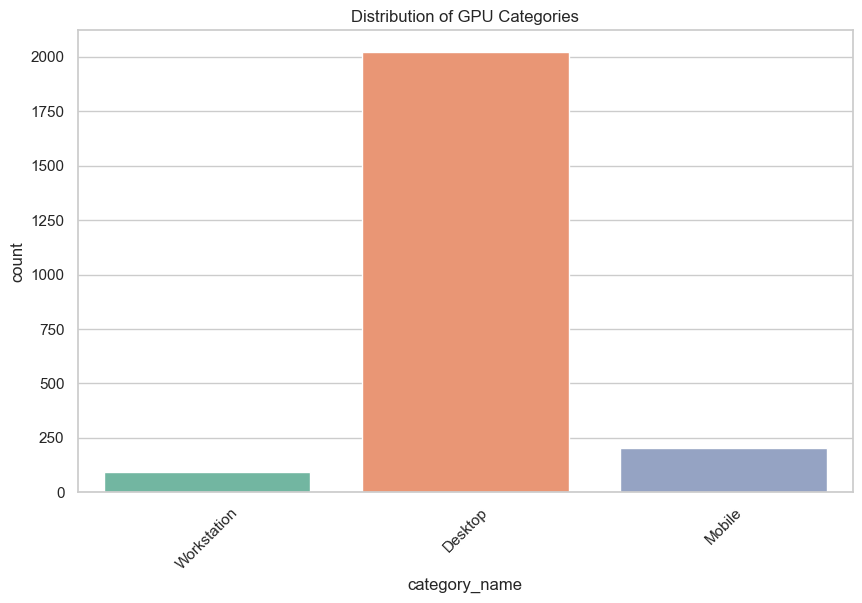

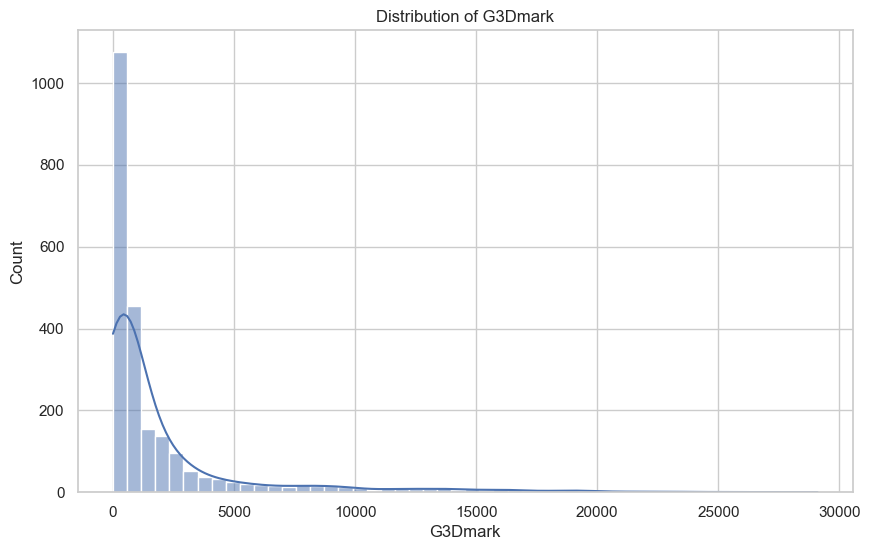

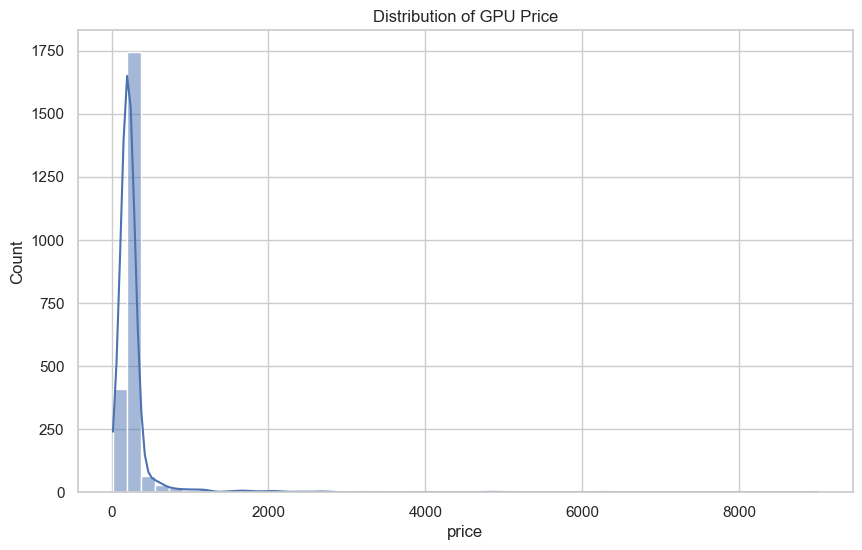

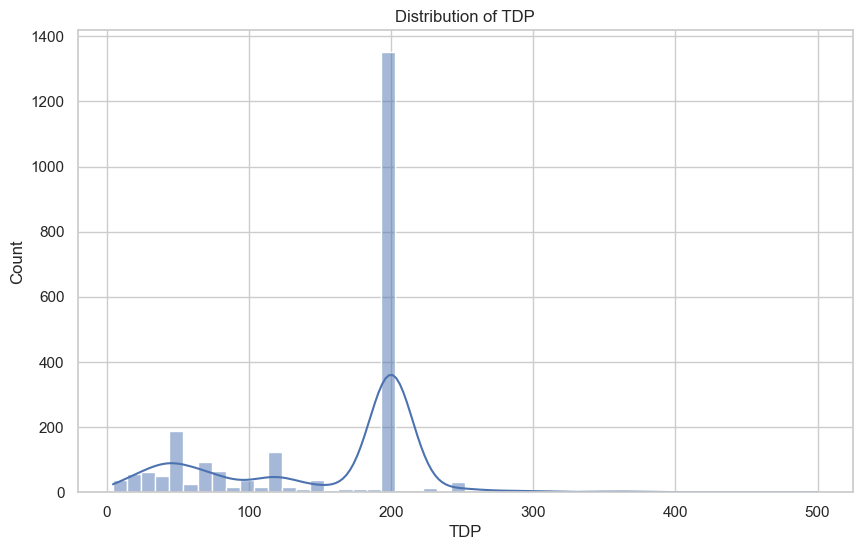

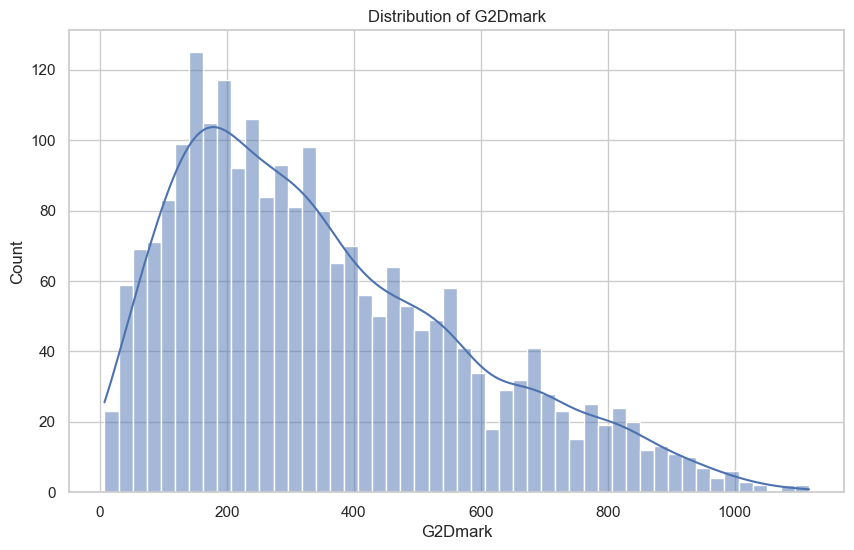

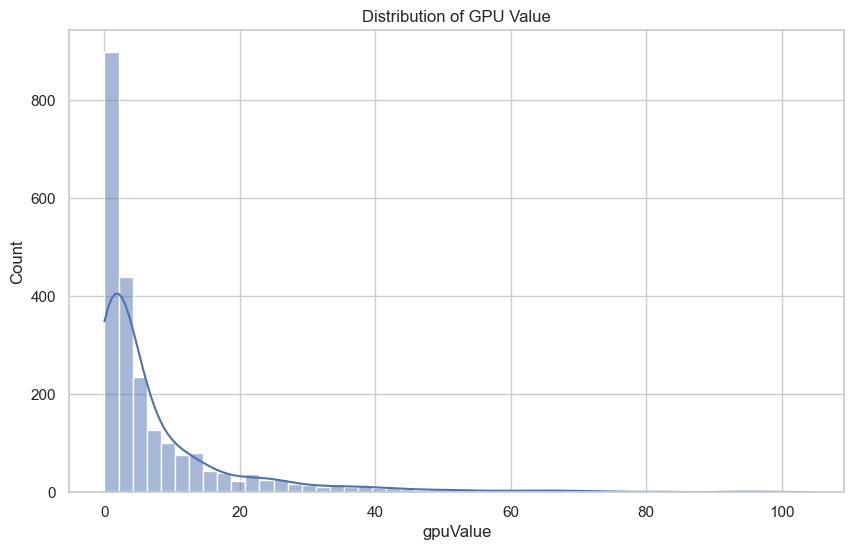

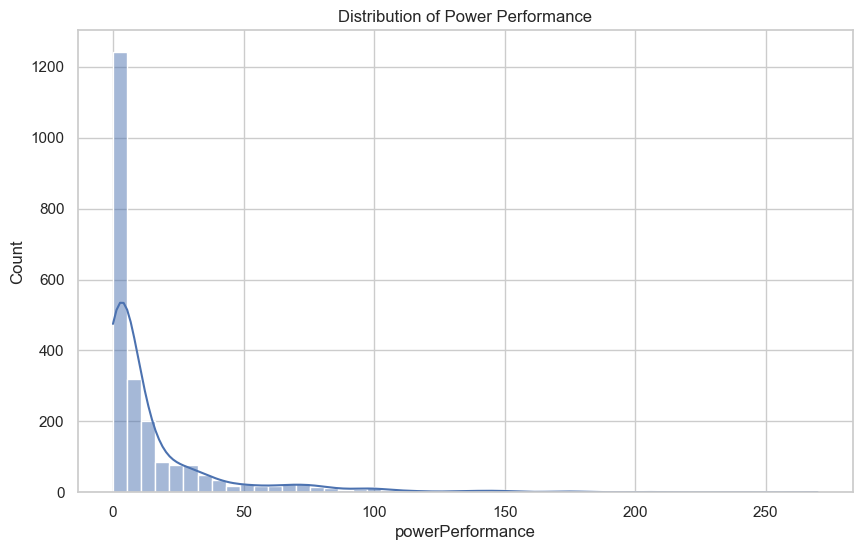

GPU_ID              0
GPU_Name            0
TDP                 0
category_name       0
G3Dmark             0
G2Dmark             0
gpuValue            0
powerPerformance    0
price               0
dtype: int64
Train set size: 1853 samples
Test set size: 464 samples

Training set category distribution:
category_name
Desktop        1616
Mobile          162
Workstation      75
Name: count, dtype: int64

Test set category distribution:
category_name
Desktop        405
Mobile          40
Workstation     19
Name: count, dtype: int64


In [5]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# Step 1: Connect to the SQLite Database
db_path = '/Users/kaushalshivaprakash/Desktop/ML project1/gpu_data.db'
conn = sqlite3.connect(db_path)

# Step 2: SQL Join Statement to Fetch Data (updated to use rowid)
query = """
SELECT 
    g.rowid AS GPU_ID,
    g.GPU_Name,
    g.TDP,
    c.category_name,
    p.G3Dmark,
    p.G2Dmark,
    p.gpuValue,
    p.powerPerformance,
    p.price
FROM 
    GPUs g
JOIN 
    Categories c ON g.category_id = c.category_id
JOIN 
    Performance p ON g.rowid = p.GPU_ID
"""

# Step 3: Execute the query and load into a DataFrame
gpu_performance_data = pd.read_sql(query, conn)

# Step 4: Visualizations for all relevant columns
sns.set(style="whitegrid")

# Plot the distribution of GPU categories
plt.figure(figsize=(10, 6))
sns.countplot(data=gpu_performance_data, x='category_name', hue='category_name', palette='Set2', legend=False)
plt.title('Distribution of GPU Categories')
plt.xticks(rotation=45)
plt.show()

# Plot the distribution of G3Dmark
plt.figure(figsize=(10, 6))
sns.histplot(gpu_performance_data['G3Dmark'], bins=50, kde=True)
plt.title('Distribution of G3Dmark')
plt.show()

# Plot the distribution of price
plt.figure(figsize=(10, 6))
sns.histplot(gpu_performance_data['price'], bins=50, kde=True)
plt.title('Distribution of GPU Price')
plt.show()

# Plot the distribution of TDP (Thermal Design Power)
plt.figure(figsize=(10, 6))
sns.histplot(gpu_performance_data['TDP'], bins=50, kde=True)
plt.title('Distribution of TDP')
plt.show()

# Plot the distribution of G2Dmark (2D performance metric)
plt.figure(figsize=(10, 6))
sns.histplot(gpu_performance_data['G2Dmark'], bins=50, kde=True)
plt.title('Distribution of G2Dmark')
plt.show()

# Plot the distribution of gpuValue (price-performance ratio)
plt.figure(figsize=(10, 6))
sns.histplot(gpu_performance_data['gpuValue'], bins=50, kde=True)
plt.title('Distribution of GPU Value')
plt.show()

# Plot the distribution of powerPerformance (performance per watt)
plt.figure(figsize=(10, 6))
sns.histplot(gpu_performance_data['powerPerformance'], bins=50, kde=True)
plt.title('Distribution of Power Performance')
plt.show()

# Step 5: Check for nulls in key columns
print(gpu_performance_data.isnull().sum())

# Step 6: Data splitting for machine learning preparation
X = gpu_performance_data.drop(['GPU_ID', 'GPU_Name', 'G3Dmark'], axis=1)  # Dropping non-features
y = gpu_performance_data['G3Dmark']  # Target variable

# Perform the train/test split (stratifying by category_name if necessary)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=gpu_performance_data['category_name'])

print(f"Train set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")

train_category_dist = X_train['category_name'].value_counts()
test_category_dist = X_test['category_name'].value_counts()

print("\nTraining set category distribution:")
print(train_category_dist)

print("\nTest set category distribution:")
print(test_category_dist)

# Step 7: Close the database connection
conn.close()


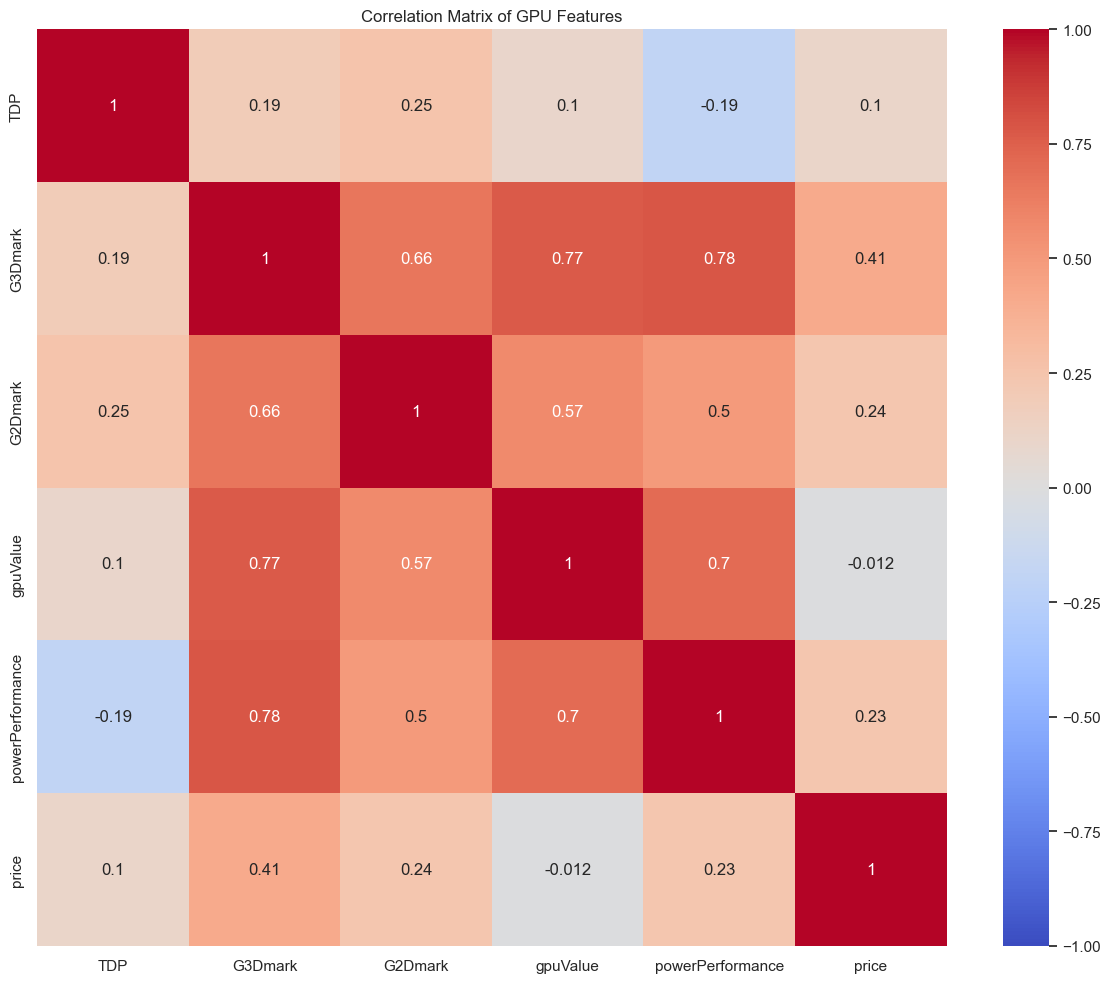

In [6]:
import pandas as pd
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt

# Connect to the SQLite database
db_path = '/Users/kaushalshivaprakash/Desktop/ML project1/gpu_data.db'
conn = sqlite3.connect(db_path)

# Load data from the database
query = """
SELECT g.rowid AS GPU_ID, g.GPU_Name, g.TDP, c.category_name, 
       p.G3Dmark, p.G2Dmark, p.gpuValue, p.powerPerformance, p.price
FROM GPUs g
JOIN Categories c ON g.category_id = c.category_id
JOIN Performance p ON g.rowid = p.GPU_ID
"""
df = pd.read_sql_query(query, conn)

# Create a correlation matrix
numeric_columns = ['TDP', 'G3Dmark', 'G2Dmark', 'gpuValue', 'powerPerformance', 'price']
correlation_matrix = df[numeric_columns].corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Matrix of GPU Features')
plt.tight_layout()
plt.savefig('correlation_matrix.png', dpi=200, bbox_inches='tight')
plt.show()

# Close the database connection
conn.close()


In [7]:
# Generate the YData Profiling report
from ydata_profiling import ProfileReport
profile = ProfileReport(df, title="GPU Data Profiling Report")
profile.to_file("gpu_data_report.html")
profile


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [8]:
import os
os.environ['MLFLOW_TRACKING_URI'] = "https://dagshub.com/kaushal-shivaprakashan/Nvidia-GPU-benchmark-prediction.mlflow"  # Replace with your DagsHub URI
os.environ['MLFLOW_TRACKING_USERNAME'] = "kaushal-shivaprakashan"  # Replace with your DagsHub username
os.environ['MLFLOW_TRACKING_PASSWORD'] = "0859fd537cc1f97ec52644b9ce065302103ff97c"  # Replace with your DagsHub access token

In [9]:
import mlflow
mlflow.set_tracking_uri("https://dagshub.com/kaushal-shivaprakashan/Nvidia-GPU-benchmark-prediction.mlflow")  # Replace with your DagsHub repo

In [10]:
#Experiment1

import pandas as pd
import sqlite3
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix, classification_report
import mlflow
import mlflow.sklearn
import os

# Step 1: Load Data from SQLite Database
db_path = '/Users/kaushalshivaprakash/Desktop/ML project1/gpu_data.db'
conn = sqlite3.connect(db_path)
query = """
SELECT g.rowid AS GPU_ID, g.GPU_Name, g.TDP, c.category_name, 
       p.G3Dmark, p.G2Dmark, p.gpuValue, p.powerPerformance, p.price
FROM GPUs g
JOIN Categories c ON g.category_id = c.category_id
JOIN Performance p ON g.rowid = p.GPU_ID
"""
data = pd.read_sql_query(query, conn)
conn.close()

# Step 2: Define Features and Target
X = data.drop(columns=["GPU_ID", "GPU_Name", "G3Dmark"])
y = data["G3Dmark"] > data["G3Dmark"].median()

# Ensure that the numeric columns are cast to float to avoid issues with missing values
numeric_features = ["TDP", "G2Dmark", "gpuValue", "powerPerformance", "price"]
X[numeric_features] = X[numeric_features].astype('float64')  # Casting to float64 for safe handling of missing values

categorical_features = ["category_name"]

# Step 3: Preprocessing Pipeline (Add MinMaxScaler for compliance)
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", MinMaxScaler()),  # Using MinMaxScaler as per description
    ("log_transform", FunctionTransformer(lambda x: np.log1p(np.maximum(x, 0))))
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

# Step 4: Create Full Pipeline with Logistic Regression
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(solver='lbfgs', max_iter=1000))  # Keep lbfgs solver for l2 penalty
])

# Step 5: Cross-Validation Setup (3/10 folds as per requirement)
kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
cv_results = cross_validate(pipeline, X, y, cv=kf, scoring="f1", error_score='raise')

# Log Cross-Validation Results
os.environ['MLFLOW_TRACKING_URI'] = "https://dagshub.com/kaushal-shivaprakashan/Nvidia-GPU-benchmark-prediction.mlflow"
os.environ['MLFLOW_TRACKING_USERNAME'] = "kaushal-shivaprakashan"
os.environ['MLFLOW_TRACKING_PASSWORD'] = "0859fd537cc1f97ec52644b9ce065302103ff97c"

mlflow.set_tracking_uri(os.environ['MLFLOW_TRACKING_URI'])

with mlflow.start_run():
    # Log CV Metrics
    mlflow.log_metric("cv_mean_f1", cv_results['test_score'].mean())
    mlflow.log_metric("cv_std_f1", cv_results['test_score'].std())

    # Step 6: Train Model on Full Training Data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
    pipeline.fit(X_train, y_train)

    # Step 7: Evaluate on Test Data
    y_pred = pipeline.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    # Log Metrics and Artifacts
    mlflow.log_metric("test_f1", f1)
    np.savetxt("confusion_matrix.txt", cm, delimiter=",")
    mlflow.log_artifact("confusion_matrix.txt")
    
    # Log the model with input example to avoid signature warning
    # Convert the input example to a DataFrame to match the expected type
    input_example = X_train.iloc[[0]]  # Use .iloc[[0]] to ensure it's a DataFrame
    
    mlflow.sklearn.log_model(pipeline, "logistic_regression_pipeline", input_example=input_example)

    # Hyperparameter Tuning
    param_grid = {
        "preprocessor__num__imputer__strategy": ["mean", "median"],
        "classifier__C": [0.1, 1.0, 10],
        "classifier__penalty": ["l2"]  # Use 'l2' penalty for lbfgs solver
    }
    
    grid_search = GridSearchCV(pipeline, param_grid, cv=kf, scoring="f1")
    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    mlflow.log_params(best_params)

    print("Best Parameters:", best_params)
    print("Classification Report")


Best Parameters: {'classifier__C': 10, 'classifier__penalty': 'l2', 'preprocessor__num__imputer__strategy': 'mean'}
Classification Report
🏃 View run bald-goat-24 at: https://dagshub.com/kaushal-shivaprakashan/Nvidia-GPU-benchmark-prediction.mlflow/#/experiments/0/runs/c9aed6e8f7f64c3fac2e8a9008568904
🧪 View experiment at: https://dagshub.com/kaushal-shivaprakashan/Nvidia-GPU-benchmark-prediction.mlflow/#/experiments/0


In [11]:
#Experiment 2

Class distribution in target variable y:
G3Dmark
False    1159
True     1158
Name: count, dtype: int64


/opt/anaconda3/lib/python3.12/site-packages/mlflow/types/utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(



Model: LogisticRegression
F1 Score: 0.987012987012987
Confusion Matrix:
[[230   2]
 [  4 228]]
Classification Report:
              precision    recall  f1-score   support

       False       0.98      0.99      0.99       232
        True       0.99      0.98      0.99       232

    accuracy                           0.99       464
   macro avg       0.99      0.99      0.99       464
weighted avg       0.99      0.99      0.99       464

🏃 View run LogisticRegression at: https://dagshub.com/kaushal-shivaprakashan/Nvidia-GPU-benchmark-prediction.mlflow/#/experiments/2/runs/2263f1f5432c432f9c6e18fa11abb548
🧪 View experiment at: https://dagshub.com/kaushal-shivaprakashan/Nvidia-GPU-benchmark-prediction.mlflow/#/experiments/2


/opt/anaconda3/lib/python3.12/site-packages/mlflow/types/utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(



Model: RidgeClassifier
F1 Score: 0.9490022172949002
Confusion Matrix:
[[227   5]
 [ 18 214]]
Classification Report:
              precision    recall  f1-score   support

       False       0.93      0.98      0.95       232
        True       0.98      0.92      0.95       232

    accuracy                           0.95       464
   macro avg       0.95      0.95      0.95       464
weighted avg       0.95      0.95      0.95       464

🏃 View run RidgeClassifier at: https://dagshub.com/kaushal-shivaprakashan/Nvidia-GPU-benchmark-prediction.mlflow/#/experiments/2/runs/5774be63039e4b929b9f3c51aa4c64de
🧪 View experiment at: https://dagshub.com/kaushal-shivaprakashan/Nvidia-GPU-benchmark-prediction.mlflow/#/experiments/2


/opt/anaconda3/lib/python3.12/site-packages/mlflow/types/utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(



Model: RandomForestClassifier
F1 Score: 0.9891067538126361
Confusion Matrix:
[[232   0]
 [  5 227]]
Classification Report:
              precision    recall  f1-score   support

       False       0.98      1.00      0.99       232
        True       1.00      0.98      0.99       232

    accuracy                           0.99       464
   macro avg       0.99      0.99      0.99       464
weighted avg       0.99      0.99      0.99       464

🏃 View run RandomForestClassifier at: https://dagshub.com/kaushal-shivaprakashan/Nvidia-GPU-benchmark-prediction.mlflow/#/experiments/2/runs/f4ecd8c3c2324383a0f648dae78b5adf
🧪 View experiment at: https://dagshub.com/kaushal-shivaprakashan/Nvidia-GPU-benchmark-prediction.mlflow/#/experiments/2


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:32:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/mlflow/types/utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt


Model: XGBClassifier
F1 Score: 0.9891067538126361
Confusion Matrix:
[[232   0]
 [  5 227]]
Classification Report:
              precision    recall  f1-score   support

       False       0.98      1.00      0.99       232
        True       1.00      0.98      0.99       232

    accuracy                           0.99       464
   macro avg       0.99      0.99      0.99       464
weighted avg       0.99      0.99      0.99       464

🏃 View run XGBClassifier at: https://dagshub.com/kaushal-shivaprakashan/Nvidia-GPU-benchmark-prediction.mlflow/#/experiments/2/runs/cda14983ef364e47998a7310a449d44b
🧪 View experiment at: https://dagshub.com/kaushal-shivaprakashan/Nvidia-GPU-benchmark-prediction.mlflow/#/experiments/2


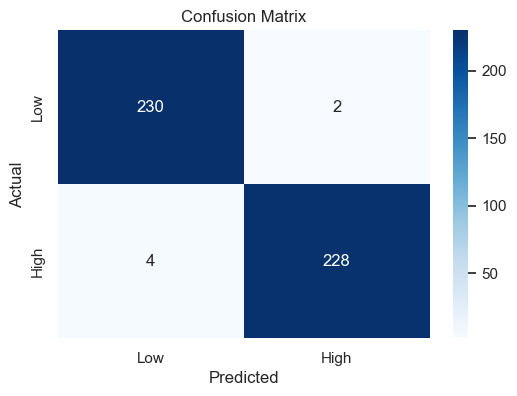

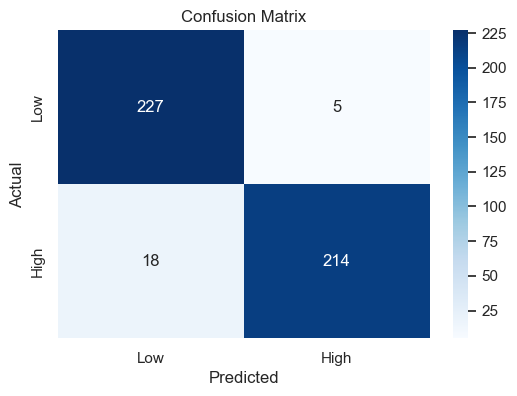

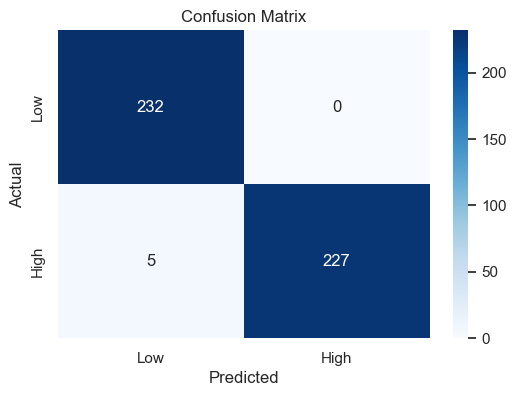

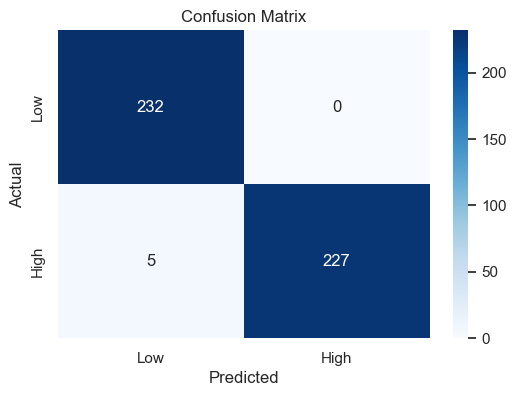

In [131]:
import pandas as pd
import sqlite3
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.metrics import f1_score, confusion_matrix, classification_report
import mlflow
import mlflow.sklearn
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Load Data from SQLite Database
db_path = '/Users/kaushalshivaprakash/Desktop/ML project1/gpu_data.db'
conn = sqlite3.connect(db_path)

# Query to fetch required data
query = """
SELECT g.rowid AS GPU_ID, g.GPU_Name, g.TDP, c.category_name, 
       p.G3Dmark, p.G2Dmark, p.gpuValue, p.powerPerformance, p.price
FROM GPUs g
JOIN Categories c ON g.category_id = c.category_id
JOIN Performance p ON g.rowid = p.GPU_ID
"""
data = pd.read_sql_query(query, conn)
conn.close()

# Step 2: Define Features and Target
X = data.drop(columns=["GPU_ID", "GPU_Name", "G3Dmark"])
y = data["G3Dmark"] > data["G3Dmark"].median()  # Binary classification (high/low G3Dmark)

# Check class distribution
print("Class distribution in target variable y:")
print(y.value_counts())

# Step 3: Preprocessing Pipeline
numeric_features = ["TDP", "G2Dmark", "gpuValue", "powerPerformance", "price"]
categorical_features = ["category_name"]

# Numeric Transformer: Handle missing values first, then scale, and log transform
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="mean")),  # Impute missing values with mean
    ("log_transform", FunctionTransformer(np.log1p, validate=True)),  # Log transformation
    ("scaler", StandardScaler())  # Standard scaling
])

# Categorical Transformer: Handle missing values and one-hot encoding
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),  # Impute missing values with most frequent value
    ("onehot", OneHotEncoder(handle_unknown="ignore"))     # One-hot encoding for categorical variables
])

# Preprocessor: Apply both numeric and categorical transformers
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

# Step 4: Define Models
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, class_weight='balanced'),  # Use class weights
    "RidgeClassifier": RidgeClassifier(),
    "RandomForestClassifier": RandomForestClassifier(random_state=42),
    "XGBClassifier": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# Step 5: Cross-Validation Setup
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Log to MLFlow
os.environ['MLFLOW_TRACKING_URI'] = "https://dagshub.com/kaushal-shivaprakashan/Nvidia-GPU-benchmark-prediction.mlflow"
os.environ['MLFLOW_TRACKING_USERNAME'] = "kaushal-shivaprakashan"
os.environ['MLFLOW_TRACKING_PASSWORD'] = "0859fd537cc1f97ec52644b9ce065302103ff97c"
mlflow.set_tracking_uri(os.environ['MLFLOW_TRACKING_URI'])

for model_name, model in models.items():
    pipeline = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("classifier", model)
    ])

    with mlflow.start_run(run_name=model_name):
        # Step 6: Cross-Validation (skip for models with GridSearchCV)
        if model_name not in ["RandomForestClassifier", "XGBClassifier"]:
            cv_results = cross_val_score(pipeline, X, y, cv=kf, scoring="f1")
            mlflow.log_metric("cv_mean_f1", cv_results.mean())
            mlflow.log_metric("cv_std_f1", cv_results.std())

        # Step 7: Train Model on Full Training Data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
        pipeline.fit(X_train, y_train)

        # Step 8: Evaluate on Test Data
        y_pred = pipeline.predict(X_test)
        f1 = f1_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)
        report = classification_report(y_test, y_pred)

        # Log Metrics
        mlflow.log_metric("test_f1", f1)

        # Save confusion matrix as a text file
        cm_file = "confusion_matrix.txt"
        np.savetxt(cm_file, cm, fmt='%d')
        mlflow.log_artifact(cm_file)

        # Save classification report as a text file
        report_file = "classification_report.txt"
        with open(report_file, "w") as f:
            f.write(report)
        mlflow.log_artifact(report_file)

        # Save confusion matrix as an image (heatmap)
        cm_file_image = "confusion_matrix.png"
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.savefig(cm_file_image)
        mlflow.log_artifact(cm_file_image)

        # Log the model pipeline with input example to infer the signature
        # Convert X_train into a DataFrame to use column names
        input_example_df = X_train.iloc[0:1]  # Get a single row as DataFrame
        mlflow.sklearn.log_model(pipeline, f"{model_name}_pipeline", input_example=input_example_df)

        # Print metrics
        print(f"\nModel: {model_name}")
        print(f"F1 Score: {f1}")
        print(f"Confusion Matrix:\n{cm}")
        print(f"Classification Report:\n{report}")


In [13]:
#experiment3



In [135]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import mlflow
import mlflow.sklearn

# Step 1: Load data from CSV
def load_data_from_csv(csv_file):
    df = pd.read_csv(csv_file)
    print("Data loaded successfully from CSV.")
    print("First 5 rows:\n", df.head())
    print("\nColumn names in the dataset:\n", df.columns)
    
    # Clean column names (strip whitespace and make lowercase for consistency)
    df.columns = df.columns.str.strip().str.lower()
    print("\nCleaned column names:\n", df.columns)
    
    # Map existing columns to expected ones
    column_mapping = {
        'g3dmark': 'benchmark_score',
        'tdp': 'cores',
        'gpuvalue': 'memory'
    }
    df = df.rename(columns=column_mapping)
    
    # Verify required columns
    required_columns = {'cores', 'memory', 'benchmark_score'}
    if not required_columns.issubset(set(df.columns)):
        raise ValueError(f"Missing required columns: {required_columns - set(df.columns)}")
    
    return df

# Load the data
raw_data_path = '/Users/kaushalshivaprakash/Desktop/ML project1/GPU_benchmarks1.csv'
df = load_data_from_csv(raw_data_path)

# Step 2: Feature Engineering and Attribute Combination
df['cores_memory_ratio'] = df['cores'] / df['memory']  # Ratio of cores to memory
df['cores_memory_interaction'] = df['cores'] * df['memory']
df['log_benchmark_score'] = np.log(df['benchmark_score'])  # Log transformation of the target

# Step 3: Separate features and target
target_column = 'benchmark_score'
X = df.drop(columns=[target_column])
y = df[target_column]

# Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

print("\nNumeric Features:", numeric_features)
print("Categorical Features:", categorical_features)

# Step 4: Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 5: Create preprocessing pipelines for numeric and categorical features
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Step 6: Define the model
model = RandomForestRegressor(random_state=42)

# Step 7: Create the full pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', model)
])

# Step 8: Hyperparameter tuning using GridSearchCV
param_grid = {
    'regressor__n_estimators': [50, 100, 200],
    'regressor__max_depth': [None, 10, 20],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4]
}

search = GridSearchCV(pipeline, param_grid, cv=3, scoring='neg_mean_squared_error', verbose=2)

# Step 9: Train the model with the best parameters
search.fit(X_train, y_train)

# Step 10: Evaluate the model
y_pred = search.best_estimator_.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\nMean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

# Step 11: Log results with MLflow
mlflow.set_experiment("GPU Benchmark Prediction - Experiment #3")

with mlflow.start_run():
    # Log the best hyperparameters, metrics, and model
    mlflow.log_param("best_params", search.best_params_)
    mlflow.log_metric("mse", mse)
    mlflow.log_metric("r2", r2)
    
    # Create an input example (first row of the test set for example)
    input_example = X_test.iloc[0:1]  # Select the first row from the test set

    # Log the model with the input example
    mlflow.sklearn.log_model(search.best_estimator_, "model", input_example=input_example)
    
    print("\nLogged data and model in MLflow.")


Data loaded successfully from CSV.
First 5 rows:
                gpuName  G3Dmark  G2Dmark    price   gpuValue    TDP  \
0  GeForce RTX 3090 Ti    29094     1117  2099.99  13.854352  450.0   
1  GeForce RTX 3080 Ti    26887     1031  1199.99  22.406020  350.0   
2     GeForce RTX 3090    26395      999  1749.99  15.082943  350.0   
3    Radeon RX 6900 XT    25458     1102  1120.31  22.724067  300.0   
4     GeForce RTX 3080    24853     1003   999.00  24.877878  320.0   

   powerPerformance  testDate category  
0         64.653333      2022  Unknown  
1         76.820000      2021  Desktop  
2         75.414286      2020  Desktop  
3         84.860000      2020  Desktop  
4         77.665625      2020  Desktop  

Column names in the dataset:
 Index(['gpuName', 'G3Dmark', 'G2Dmark', 'price', 'gpuValue', 'TDP',
       'powerPerformance', 'testDate', 'category'],
      dtype='object')

Cleaned column names:
 Index(['gpuname', 'g3dmark', 'g2dmark', 'price', 'gpuvalue', 'tdp',
       'powe

/opt/anaconda3/lib/python3.12/site-packages/mlflow/types/utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(



Logged data and model in MLflow.
🏃 View run respected-foal-20 at: https://dagshub.com/kaushal-shivaprakashan/Nvidia-GPU-benchmark-prediction.mlflow/#/experiments/2/runs/7246c53c4a1147eea0a98a55b9b0854f
🧪 View experiment at: https://dagshub.com/kaushal-shivaprakashan/Nvidia-GPU-benchmark-prediction.mlflow/#/experiments/2


In [15]:
#Experiment 4

Data columns: Index(['gpuName', 'G3Dmark', 'G2Dmark', 'price', 'gpuValue', 'TDP',
       'powerPerformance', 'testDate', 'category'],
      dtype='object')
Shape of numeric_data: (2317, 7)
Mean Squared Error: 3.8593864213012434
R² Score: 0.9756405239508712


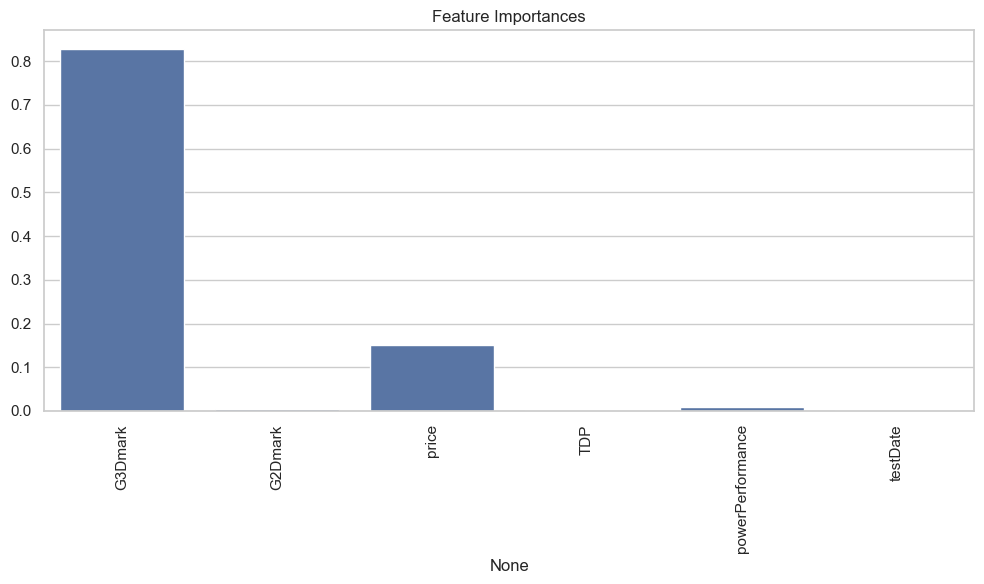

🏃 View run rare-snake-583 at: https://dagshub.com/kaushal-shivaprakashan/Nvidia-GPU-benchmark-prediction.mlflow/#/experiments/7/runs/f71196b53fa34322aaa52c7c3407ce2e
🧪 View experiment at: https://dagshub.com/kaushal-shivaprakashan/Nvidia-GPU-benchmark-prediction.mlflow/#/experiments/7


In [105]:
import sqlite3
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import mlflow

# Connect to the SQLite database (replace with CSV if necessary)
db_path = '/Users/kaushalshivaprakash/Desktop/ML project1/gpu_data.db'
data = pd.read_csv(db_path)

# Print the data columns to debug
print("Data columns:", data.columns)

# Preprocessing
# Select numeric columns and drop rows with missing values
numeric_data = data.select_dtypes(include=[np.number]).dropna()

# Print shape of numeric data
print("Shape of numeric_data:", numeric_data.shape)

# Define target variable and features
target = 'gpuValue'  # Replace with your actual target column name
features = numeric_data.drop(columns=[target])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, numeric_data[target], test_size=0.2, random_state=42)

# Train a RandomForestRegressor
clf = RandomForestRegressor(random_state=42)
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Calculate regression metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print regression metrics
print(f"Mean Squared Error: {mse}")
print(f"R² Score: {r2}")

# Plot feature importances
feature_importances = clf.feature_importances_
features_names = features.columns
plt.figure(figsize=(10, 6))
sns.barplot(x=features_names, y=feature_importances)
plt.title("Feature Importances")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Log results to MLflow
mlflow.set_experiment("Random Forest Regression Experiment")
with mlflow.start_run():
    mlflow.log_metric("num_features", features.shape[1])  # Only log after 'features' is defined
    mlflow.log_metric("MSE", mse)
    mlflow.log_metric("R2", r2)
    # Optionally log the plot if saved
    # mlflow.log_artifact("feature_importances.png")  # Save the plot to a file if needed


In [17]:
#Experiment 5

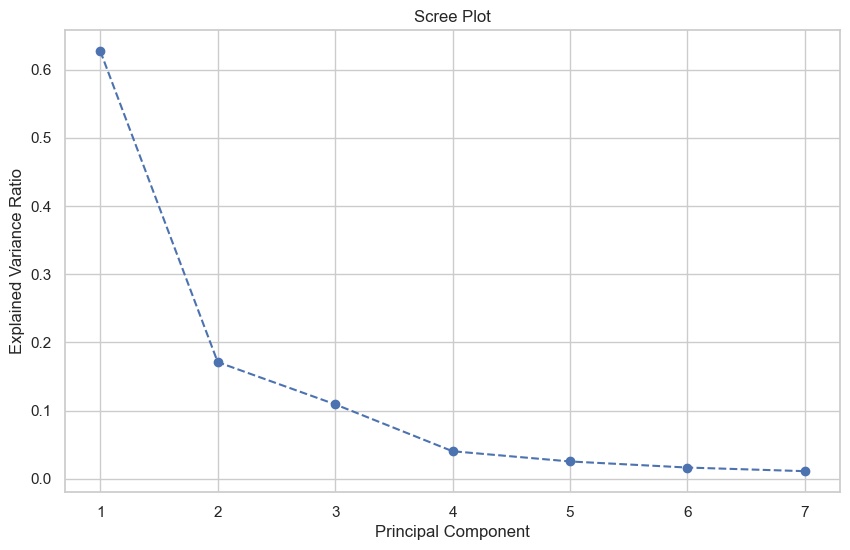

🏃 View run able-deer-508 at: https://dagshub.com/kaushal-shivaprakashan/Nvidia-GPU-benchmark-prediction.mlflow/#/experiments/3/runs/361af8aef0b140099034628b5195d4e5
🧪 View experiment at: https://dagshub.com/kaushal-shivaprakashan/Nvidia-GPU-benchmark-prediction.mlflow/#/experiments/3
PCA analysis completed and results logged to MLFlow. Scree plot saved at: /Users/kaushalshivaprakash/Desktop/ML project1/scree_plot.png


In [18]:
import sqlite3
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import mlflow
import os

# Connect to SQLite database and fetch data from a specified table
db_path = '/Users/kaushalshivaprakash/Desktop/ML project1/gpu_data.db'
conn = sqlite3.connect(db_path)
table_name = 'gpu_data'  # Specify the table name

# Load the table into a Pandas DataFrame
df = pd.read_sql_query(f"SELECT * FROM {table_name}", conn)
conn.close()

# Preprocess data (remove non-numeric columns, handle NaNs)
df_numeric = df.select_dtypes(include=['float64', 'int64']).dropna()

# Standardize features
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_numeric)

# Apply PCA
pca = PCA()
pca_result = pca.fit_transform(df_scaled)

# Create a scree plot
explained_variance = pca.explained_variance_ratio_
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.xticks(range(1, len(explained_variance) + 1))
plt.grid(True)

# Save the scree plot in the current directory
plot_path = os.path.join(os.getcwd(), 'scree_plot.png')
plt.savefig(plot_path)
plt.show()

# Ensure MLFlow experiment exists or create it
experiment_name = "PCA Experiment"
if not mlflow.get_experiment_by_name(experiment_name):
    mlflow.create_experiment(experiment_name)
mlflow.set_experiment(experiment_name)

# Log results to MLFlow
with mlflow.start_run():
    mlflow.log_param("Number of components", len(explained_variance))
    mlflow.log_metric("Explained Variance Sum", sum(explained_variance))
    mlflow.log_artifact(plot_path)  # Log the scree plot
    mlflow.log_text(str(explained_variance), "explained_variance.txt")

print(f"PCA analysis completed and results logged to MLFlow. Scree plot saved at: {plot_path}")


In [19]:
import sqlite3
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import mlflow
import os
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight

# Connect to SQLite database and fetch data from a specified table
db_path = '/Users/kaushalshivaprakash/Desktop/ML project1/gpu_data.db'
conn = sqlite3.connect(db_path)
table_name = 'gpu_data'  # Specify the table name

# Load the table into a Pandas DataFrame
df = pd.read_sql_query(f"SELECT * FROM {table_name}", conn)
conn.close()

# Print column names to check for the target column
print("Columns in the dataset:", df.columns)

# Separate the target column ('category') and drop non-numeric columns
target_column = 'category'

# Extract the target column 'category' first
y = df[target_column]

# Now drop the target column and any other non-numeric columns (like 'gpuName' and 'testDate')
df_numeric = df.drop(columns=[target_column, 'gpuName', 'testDate'])

# Drop rows with missing values from both the features and the target
df_numeric = df_numeric.dropna()
y = y[df_numeric.index]  # Ensure the target variable matches the cleaned feature set

# Extract features (X) from the numeric data
X = df_numeric

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=5)  # Adjust number of components as needed
X_pca = pca.fit_transform(X_scaled)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Handle class imbalance by using class_weight='balanced' in Logistic Regression
class_weights = compute_class_weight('balanced', classes=y.unique(), y=y_train)
class_weight_dict = dict(zip(y.unique(), class_weights))

# Train a Logistic Regression model with class weighting
model = LogisticRegression(random_state=42, class_weight=class_weight_dict)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_report_text = classification_report(y_test, y_pred, zero_division=1)

# Log results to MLFlow
experiment_name = "Custom Experiment"
if not mlflow.get_experiment_by_name(experiment_name):
    mlflow.create_experiment(experiment_name)
mlflow.set_experiment(experiment_name)

with mlflow.start_run():
    mlflow.log_param("PCA Components", pca.n_components_)
    mlflow.log_param("Model", "Logistic Regression")
    mlflow.log_metric("Accuracy", accuracy)
    mlflow.log_text(classification_report_text, "classification_report.txt")
    mlflow.log_text(str(pca.explained_variance_ratio_), "explained_variance_ratio.txt")

print(f"Experiment completed. Accuracy: {accuracy:.2f}")
print(f"Classification Report:\n{classification_report_text}")


Columns in the dataset: Index(['gpuName', 'G3Dmark', 'G2Dmark', 'price', 'gpuValue', 'TDP',
       'powerPerformance', 'testDate', 'category'],
      dtype='object')
🏃 View run likeable-squid-680 at: https://dagshub.com/kaushal-shivaprakashan/Nvidia-GPU-benchmark-prediction.mlflow/#/experiments/4/runs/ae313a73da384a2ba33c86039349cafc
🧪 View experiment at: https://dagshub.com/kaushal-shivaprakashan/Nvidia-GPU-benchmark-prediction.mlflow/#/experiments/4
Experiment completed. Accuracy: 0.60
Classification Report:
                     precision    recall  f1-score   support

            Desktop       0.82      0.77      0.79        47
             Mobile       0.17      0.60      0.26         5
Mobile, Workstation       0.00      1.00      0.00         0
            Unknown       0.25      1.00      0.40         1
        Workstation       0.78      0.28      0.41        25

           accuracy                           0.60        78
          macro avg       0.40      0.73      0.37     

In [20]:
#experiment7

In [21]:
import sqlite3
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
import mlflow

# Load data
db_path = '/Users/kaushalshivaprakash/Desktop/ML project1/gpu_data.db'
conn = sqlite3.connect(db_path)
df = pd.read_sql_query("SELECT * FROM gpu_data", conn)
conn.close()

# Preprocess data
target_column = 'category'
y = df[target_column]
df_numeric = df.drop(columns=[target_column, 'gpuName', 'testDate']).dropna()
y = y[df_numeric.index]
X = df_numeric

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_scaled)

# Handle imbalance using SMOTE with adjusted neighbors
smote = SMOTE(random_state=42, k_neighbors=2)
X_resampled, y_resampled = smote.fit_resample(X_pca, y)

# Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

# Train Random Forest Classifier
model = RandomForestClassifier(random_state=42, n_estimators=100, class_weight='balanced')
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_report_text = classification_report(y_test, y_pred, zero_division=0)

# Log results to MLFlow
experiment_name = "Custom Experiment 7: Random Forest"
if not mlflow.get_experiment_by_name(experiment_name):
    mlflow.create_experiment(experiment_name)
mlflow.set_experiment(experiment_name)

with mlflow.start_run():
    mlflow.log_param("PCA Components", pca.n_components_)
    mlflow.log_param("Model", "Random Forest Classifier")
    mlflow.log_param("n_estimators", 100)
    mlflow.log_metric("Accuracy", accuracy)
    mlflow.log_text(classification_report_text, "classification_report.txt")
    mlflow.log_text(str(pca.explained_variance_ratio_), "explained_variance_ratio.txt")

# Print results
print(f"Experiment completed. Accuracy: {accuracy:.2f}")
print(f"Classification Report:\n{classification_report_text}")


🏃 View run resilient-hog-827 at: https://dagshub.com/kaushal-shivaprakashan/Nvidia-GPU-benchmark-prediction.mlflow/#/experiments/5/runs/f664b298396b4505b9c58c8b742a85cf
🧪 View experiment at: https://dagshub.com/kaushal-shivaprakashan/Nvidia-GPU-benchmark-prediction.mlflow/#/experiments/5
Experiment completed. Accuracy: 0.88
Classification Report:
                     precision    recall  f1-score   support

            Desktop       0.73      0.73      0.73        44
             Mobile       0.93      1.00      0.97        43
Mobile, Workstation       0.98      1.00      0.99        43
            Unknown       0.98      1.00      0.99        44
        Workstation       0.74      0.65      0.69        43

           accuracy                           0.88       217
          macro avg       0.87      0.88      0.87       217
       weighted avg       0.87      0.88      0.87       217



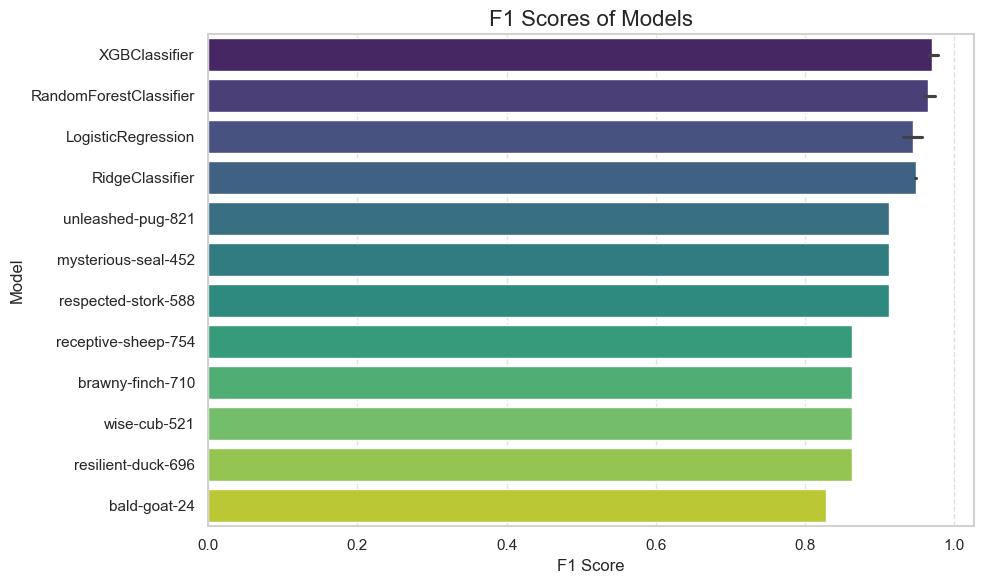

In [22]:
import mlflow
from mlflow.tracking import MlflowClient
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Suppress runtime warnings (optional)
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Initialize the MLflow client
client = MlflowClient()

# Fetch all experiments
experiments = client.search_experiments()

# Initialize a list to store results
results = []

# Iterate through experiments and their runs
for experiment in experiments:
    runs = client.search_runs(experiment.experiment_id)
    for run in runs:
        model_name = run.data.tags.get("mlflow.runName", "Unknown")
        f1_score = run.data.metrics.get("test_f1", None)
        if f1_score is not None:
            results.append({"Model": model_name, "F1 Score": f1_score})

# Convert results to a DataFrame
df_results = pd.DataFrame(results)

# Check if the DataFrame is not empty
if not df_results.empty:
    # Sort by F1 score for better visualization
    df_results = df_results.sort_values(by="F1 Score", ascending=False)

    # Plot the F1 scores
    plt.figure(figsize=(10, 6))
    sns.barplot(
        data=df_results, 
        x="F1 Score", 
        y="Model", 
        hue="Model",  # Use Model as the hue
        palette="viridis", 
        dodge=False,  # Avoid separating bars by hue
        legend=False  # Disable the legend
    )
    plt.title("F1 Scores of Models", fontsize=16)
    plt.xlabel("F1 Score", fontsize=12)
    plt.ylabel("Model", fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()
else:
    print("No F1 scores found in the experiments.")


In [23]:
#next experiments

🏃 View run LogisticRegression at: https://dagshub.com/kaushal-shivaprakashan/Nvidia-GPU-benchmark-prediction.mlflow/#/experiments/5/runs/e80d054edfbb476485d91800298562c6
🧪 View experiment at: https://dagshub.com/kaushal-shivaprakashan/Nvidia-GPU-benchmark-prediction.mlflow/#/experiments/5
🏃 View run RandomForestClassifier at: https://dagshub.com/kaushal-shivaprakashan/Nvidia-GPU-benchmark-prediction.mlflow/#/experiments/5/runs/52a185ed3c934c66bf88dfe8acfb3f8d
🧪 View experiment at: https://dagshub.com/kaushal-shivaprakashan/Nvidia-GPU-benchmark-prediction.mlflow/#/experiments/5
🏃 View run XGBClassifier at: https://dagshub.com/kaushal-shivaprakashan/Nvidia-GPU-benchmark-prediction.mlflow/#/experiments/5/runs/47f3814688b54e628c90678399ceaf88
🧪 View experiment at: https://dagshub.com/kaushal-shivaprakashan/Nvidia-GPU-benchmark-prediction.mlflow/#/experiments/5


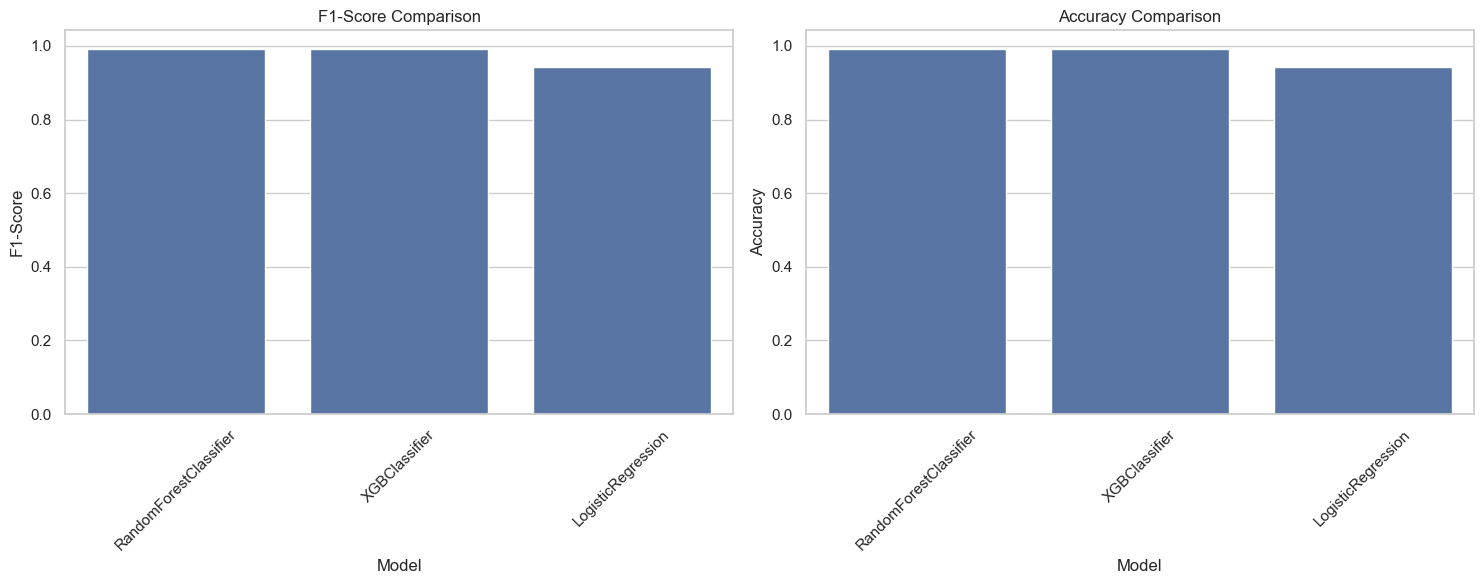

Final Model (RandomForestClassifier) Test Accuracy: 0.9892
Final Model (RandomForestClassifier) Test F1-Score: 0.9891
🏃 View run RandomForestClassifier_final_evaluation at: https://dagshub.com/kaushal-shivaprakashan/Nvidia-GPU-benchmark-prediction.mlflow/#/experiments/5/runs/dd3e2cfceecf4554ae5ee25b118148b9
🧪 View experiment at: https://dagshub.com/kaushal-shivaprakashan/Nvidia-GPU-benchmark-prediction.mlflow/#/experiments/5
The best model (RandomForestClassifier) has been saved to 'best_model.joblib'.


In [51]:
# Import necessary libraries
import pandas as pd
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, accuracy_score
import mlflow
import mlflow.sklearn
import joblib
import os

# Step 1: Connect to SQLite Database and fetch the data
db_path = '/Users/kaushalshivaprakash/Desktop/ML project1/gpu_data.db'
conn = sqlite3.connect(db_path)
query = """
SELECT g.rowid AS GPU_ID, g.GPU_Name, g.TDP, c.category_name, 
p.G3Dmark, p.G2Dmark, p.gpuValue, p.powerPerformance, p.price
FROM GPUs g
JOIN Categories c ON g.category_id = c.category_id
JOIN Performance p ON g.rowid = p.GPU_ID
"""
data = pd.read_sql_query(query, conn)
conn.close()

# Step 2: Prepare the features and target variable
X = data.drop(columns=["GPU_ID", "GPU_Name", "G3Dmark"])
y = data["G3Dmark"] > data["G3Dmark"].median()  # Binary classification (high/low G3Dmark)

# Step 3: Define preprocessing pipeline
numeric_features = ["TDP", "G2Dmark", "gpuValue", "powerPerformance", "price"]
categorical_features = ["category_name"]

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

# Step 4: Define models
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, class_weight='balanced'),
    "RandomForestClassifier": RandomForestClassifier(random_state=42),
    "XGBClassifier": XGBClassifier(eval_metric='logloss', random_state=42)
}

# Step 5: Cross-validation setup
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Step 6: Set up MLflow for tracking
os.environ['MLFLOW_TRACKING_URI'] = "https://dagshub.com/kaushal-shivaprakashan/Nvidia-GPU-benchmark-prediction.mlflow"
mlflow.set_tracking_uri(os.environ['MLFLOW_TRACKING_URI'])

# Step 7: F1-Score & Accuracy Comparison and Model Evaluation
f1_scores = []
accuracy_scores = []

for model_name, model in models.items():
    pipeline = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("classifier", model)
    ])
    
    with mlflow.start_run(run_name=model_name):
        f1_cv_results = cross_val_score(pipeline, X, y, cv=kf, scoring="f1")
        acc_cv_results = cross_val_score(pipeline, X, y, cv=kf, scoring="accuracy")
        
        mean_f1 = f1_cv_results.mean()
        mean_acc = acc_cv_results.mean()
        
        f1_scores.append((model_name, mean_f1))
        accuracy_scores.append((model_name, mean_acc))
        
        # Log metrics to MLflow
        mlflow.log_metric("cv_mean_f1", mean_f1)
        mlflow.log_metric("cv_mean_accuracy", mean_acc)

# Step 8: Plot F1 and Accuracy Scores
# Sort by F1-Score
f1_scores = sorted(f1_scores, key=lambda x: x[1], reverse=True)
accuracy_scores = sorted(accuracy_scores, key=lambda x: x[1], reverse=True)

# Extract model names and scores
model_names, f1_values = zip(*f1_scores)
_, acc_values = zip(*accuracy_scores)

# Plotting F1 and Accuracy Scores
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

sns.barplot(x=list(model_names), y=list(f1_values), ax=ax[0])
ax[0].set_title("F1-Score Comparison")
ax[0].set_ylabel("F1-Score")
ax[0].set_xlabel("Model")
ax[0].tick_params(axis='x', rotation=45)

sns.barplot(x=list(model_names), y=list(acc_values), ax=ax[1])
ax[1].set_title("Accuracy Comparison")
ax[1].set_ylabel("Accuracy")
ax[1].set_xlabel("Model")
ax[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Step 9: Save the Final Model using joblib
best_model_name = model_names[0]  # Best model by F1-score
best_model = models[best_model_name]

# Train the best model
best_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", best_model)
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
best_pipeline.fit(X_train, y_train)

# Evaluate the best model on test data
y_pred = best_pipeline.predict(X_test)
final_accuracy = accuracy_score(y_test, y_pred)
final_f1 = f1_score(y_test, y_pred)

print(f"Final Model ({best_model_name}) Test Accuracy: {final_accuracy:.4f}")
print(f"Final Model ({best_model_name}) Test F1-Score: {final_f1:.4f}")

# Log final test metrics to MLflow
with mlflow.start_run(run_name=f"{best_model_name}_final_evaluation"):
    mlflow.log_metric("final_test_accuracy", final_accuracy)
    mlflow.log_metric("final_test_f1", final_f1)

# Save the model
joblib.dump(best_pipeline, 'best_model.joblib')
print(f"The best model ({best_model_name}) has been saved to 'best_model.joblib'.")


streamit.py in folder


FastAPI.py and Docker in folder